## Import stuff

In [6]:
import sys
sys.path.append('/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi')

import numpy as np
import matplotlib.pyplot as plt
import priors as priors
import ndes as ndes
import delfi as delfi
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

## Set up the prior

In [7]:
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior = tfd.Blockwise([tfd.Uniform(low=lower[i], high=upper[i]) for i in range(5)])

## Load in the compressed data vector, sims, Fisher matrix, fiducial params
`compressed_data` is an array of length `n_summaries`<br>
`sim_params` is an array with shape `(n_simulations, n_parameters)`<br>
`sim_compressed_data` is an array with shape `(n_simulations, n_summaries)`

In [8]:
compressed_data = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/compressed_data.dat')

sim_params = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/simulations_parameters.dat')

sim_compressed_data = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/simulations_compressed_data.dat')

Finv = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/Finv.dat')

theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

## Create ensemble of NDEs

In [9]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(
            n_parameters=5,
            n_data=5,
            n_mades=5,
            n_hidden=[30,30], 
            activation=tf.keras.layers.LeakyReLU(0.01),
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None),
            all_layers=True)]

NDEs += [ndes.MixtureDensityNetwork(
            n_parameters=5,
            n_data=5, 
            n_components=i+1,
            n_hidden=[30], 
            activation=tf.keras.layers.LeakyReLU(0.01))
        for i in range(5)]

NDEs += [ndes.SinhArcSinhMADE(
            n_parameters=5,
            n_data=5,
            n_hidden=[64],
            activation=tf.tanh,
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None),
            bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None)
        )]

## Create DELFI object

In [11]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv=Finv, 
                            theta_fiducial=theta_fiducial,
                            param_limits = [lower, upper],
                            param_names=['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                            results_dir="simulators/cosmic_shear/results",
                            filename="cosmic_shear",
                            optimiser=tf.keras.optimizers.Adam(lr=1e-4),
                            optimiser_arguments=None,
                            dtype=tf.float32,
                            posterior_chain_length=200,
                            nwalkers=500,
                            input_normalization="fisher")

## Load simulations into DELFI object

In [12]:
DelfiEnsemble.load_simulations(sim_compressed_data, sim_params)

## Fisher pre-training to initialize networks

In [13]:
DelfiEnsemble.fisher_pretraining(n_batch=5000, epochs=1000, patience=20, plot=True)

KeyboardInterrupt: 

# Train the networks

In [8]:
DelfiEnsemble.train(f_val=0.1, epochs=300, n_batch=256, patience=20)

# Sample the learned posterior

In [9]:
posterior_samples, posterior_weights = DelfiEnsemble.emcee_sample()

# Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


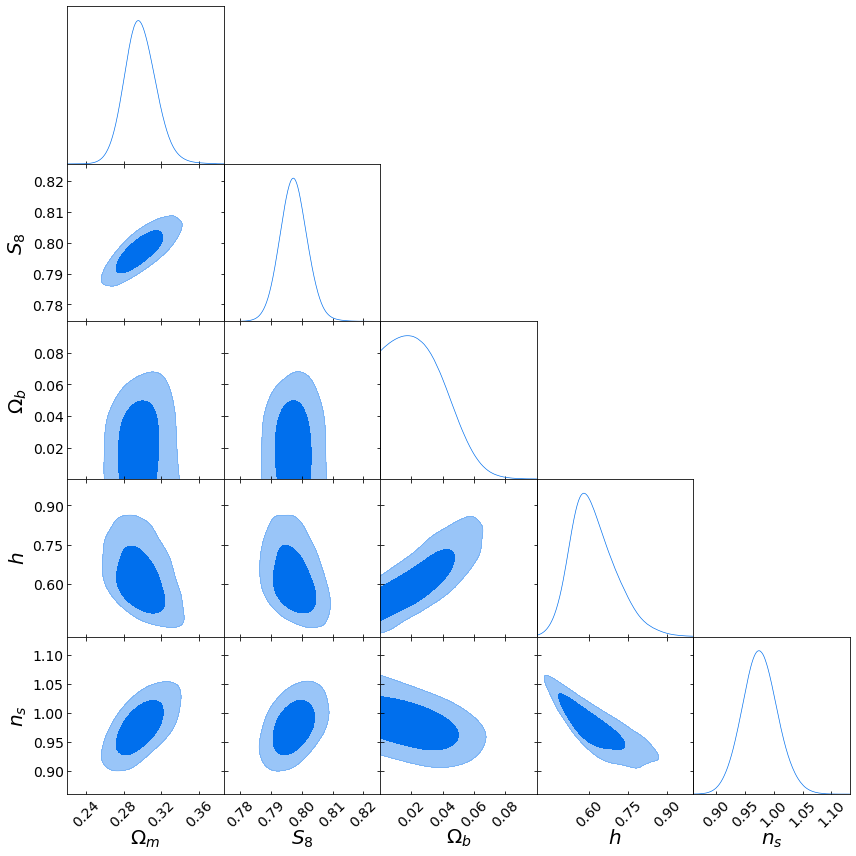

In [10]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])